<a href="https://colab.research.google.com/github/tsakailab/alpp/blob/main/colab/alpp_model_visualize_featuremaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualization of Feature Maps<br>特徴マップの可視化

What local features are examined in a CNN model of object recognition?
Let's visualize the **feature maps** computed at each layer.

物体認識のCNNモデルは，どのような局所特徴を調べているのでしょうか．**特徴マップ（feature maps）**を可視化します．

In [ ]:
#@title Define `reg_fh` to add a capability to save feature maps during forward propagation, and `plotFeaturesmaps` to visualize the saved feature maps.<br>順伝播時に特徴マップを保存する機能を追加する `reg_fh` と，保存した特徴マップを可視化する関数 `plotFeaturemaps` を定義します．
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm as tsn

# dictionary to save feature maps
featuremaps = {}

# save output in featuremaps when hooked
def hook_fn(module, input, output):
    featuremaps[module] = output


# register fh at layers of types specified by nntypes
def reg_fh(model, fh=hook_fn, nntypes=None):
    for name, layer in model._modules.items():
        if isinstance(layer, torch.nn.Sequential):
            reg_fh(layer, fh, nntypes)
        else:
            if nntypes is not None:
                if isinstance(layer, nntypes):
                    layer.register_forward_hook(fh)
            else:
                layer.register_forward_hook(fh)


# plot feature maps
def plotFeaturemaps(maps, max_ch=12, top=None, figsize=(8, 3), mag=1):

    if maps.ndim == 1:
        plt.figure(figsize=figsize)
        plt.bar(np.arange(maps.shape[0]), maps, width=1.0)
        plt.tight_layout()
        plt.show()
        return

    if maps.ndim != 3: return
    # maps.shape = (ch, h, w)
    if top is not None:
        nmaps = min(top, maps.shape[0])
        nrows, ncols = 1, nmaps
        channels = np.argsort(-np.sum(np.abs(maps.reshape((maps.shape[0],-1))**2), axis=1))[:nmaps]
    else:
        nmaps = min(maps.shape[0], max_ch*max_ch)
        ncols = int(np.ceil(np.sqrt(nmaps)))
        nrows = int(np.floor(nmaps / ncols))
        nmaps = nrows * ncols
        channels = range(nmaps)

    norm = tsn(vmin=np.minimum(maps[:].min(),-1e-6), vcenter=0, vmax=np.maximum(maps[:].max(),1e-6)) # maps[channels]
    fig = plt.figure(figsize=(ncols*mag, nrows*mag))
    for ch in range(nmaps):
        ax1 = fig.add_subplot(nrows, ncols, ch+1)
        ax1.imshow(maps[channels[ch]], cmap='bwr_r', norm=norm)#, aspect='equal')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    plt.tight_layout()
    plt.show()

## Get a pre-trained CNN model from Torchvision.<br>学習済みのCNNモデルをTorchvisionから入手します．

[If pretrained=True, returns a model pre-trained on ImageNet.](https://pytorch.org/vision/stable/models.html)

In [ ]:
import torch
from torchvision import models

#model = models.alexnet(pretrained=True)
#model = models.vgg16(pretrained=True)
model = models.vgg16_bn(pretrained=True)

#model = models.resnet50(pretrained=True)
#model = models.googlenet(pretrained=True)
#model = models.mobilenet_v3_small(pretrained=True)
#model = models.efficientnet_b0(pretrained=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.eval().to(device)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

#### Adds the ability to save feature maps to the model.<br>特徴マップを保存する機能をモデルに付加します．

`types_of_layers` should be the types of layers for which you want to store feature maps.

`types_of_layers` には，特徴マップを保存したい層の型を指定してください（複数指定可）．

In [ ]:
types_of_layers = (torch.nn.modules.conv.Conv2d,
                   #torch.nn.modules.activation.ReLU,
                   #torch.nn.modules.pooling.MaxPool2d,
                   torch.nn.modules.Linear,
)
import copy
model_fh = copy.deepcopy(model)
reg_fh(model_fh, nntypes=types_of_layers)

In [ ]:
#uri = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
#uri = "https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.amazonaws.com%2F0%2F166345%2F7358a513-a377-c29f-2a3d-4e2058990576.jpeg?ixlib=rb-4.0.0&auto=format&gif-q=60&q=75&w=1400&fit=max&s=6946b0bc6140a739bc60ddaa3a0aab8c"
uri = "http://static.independent.co.uk/s3fs-public/styles/article_large/public/thumbnails/image/2016/02/25/13/cat-getty_0.jpg"
#uri = 'http://images.cocodataset.org/test-stuff2017/000000024309.jpg'
#uri = 'http://images.cocodataset.org/test-stuff2017/000000028117.jpg'
#uri = 'http://images.cocodataset.org/test-stuff2017/000000006149.jpg'
#uri =  'http://images.cocodataset.org/test-stuff2017/000000004954.jpg'
#uri = "https://otamatone.jp/cms/wp-content/uploads/2019/09/190421_otamatone71638-300x300.jpg"

(height, width, channels) = (128, 170, 3)


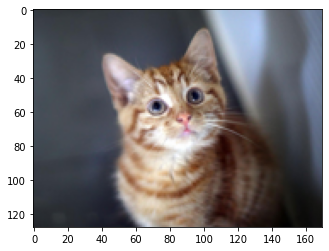

In [ ]:
#@title Downloads and displays an image.<br>画像をダウンロードして表示します．
import imageio
cimg = imageio.imread(uri)

# resize
from PIL import Image
pimg = Image.fromarray(cimg)

cimg = np.array(pimg.resize((cimg.shape[1] * 128 // cimg.shape[0], 128)))
#cimg = np.array(pimg)

print("(height, width, channels) =", cimg.shape)
import matplotlib.pyplot as plt
plt.imshow(cimg)
plt.show()

In [ ]:
#@title Creates a preprocessed image `in_img` of Torch Tensor type for object recognition.<br>物体認識用に前処理したTorch Tensor型の画像 `in_img` を作成します．
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

in_img = preprocess(pimg)

In [ ]:
#@title Inputs to the model to obtain output and feature maps.<br>モデルに入力して，出力と特徴マップを得ます．
featuremaps = {}

output = model_fh(in_img.unsqueeze(0).to(device))

print("Got featuremaps at", len(featuremaps), "layers.")
print(featuremaps.keys())

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

import os
if not os.path.exists("imagenet_classes.txt"):
    # Download ImageNet labels
    !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], "(", top5_catid[i].numpy(), ")", top5_prob[i].item())

#probs = probabilities.squeeze(0).detach().cpu().numpy()
#plt.bar(np.arange(probs.shape[0]), probs, width=1.0)
#plt.tight_layout()
#plt.show()

Got featuremaps at 16 layers.
dict_keys([Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Linear(in_features=25088, out_features=4096, bias=True), Linear(in_f

### Displays feature maps.<br>特徴マップを表示します．
- Positive and negative features are shown in blue and red.
- `plotFeaturemaps(maps, top=5)` will display the top 5 feature maps with large magnitudes.

- 青が正，赤が負の特徴量です．
- `plotFeaturemaps(maps, top=5)` のように変更すると，特徴量の多い上位5枚の特徴マップが表示されます．

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 64, 224, 224])


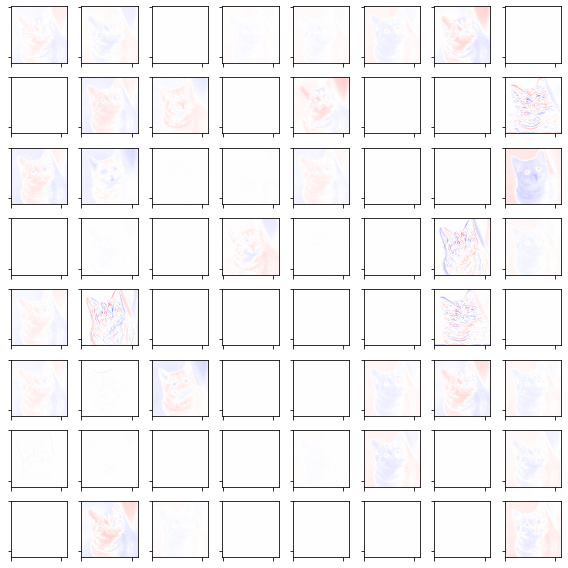

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 64, 224, 224])


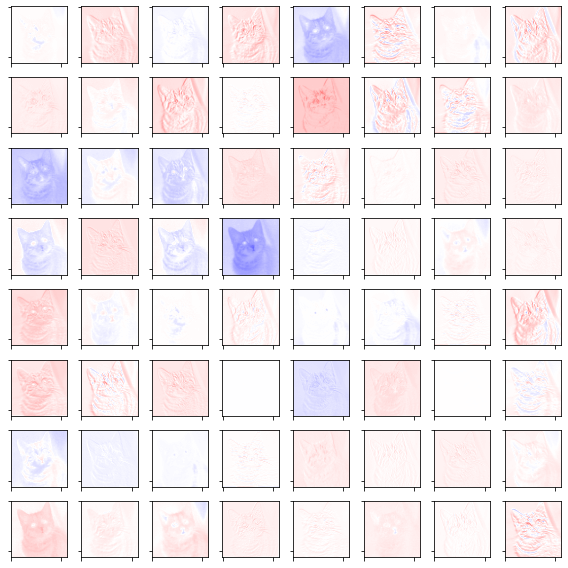

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 128, 112, 112])


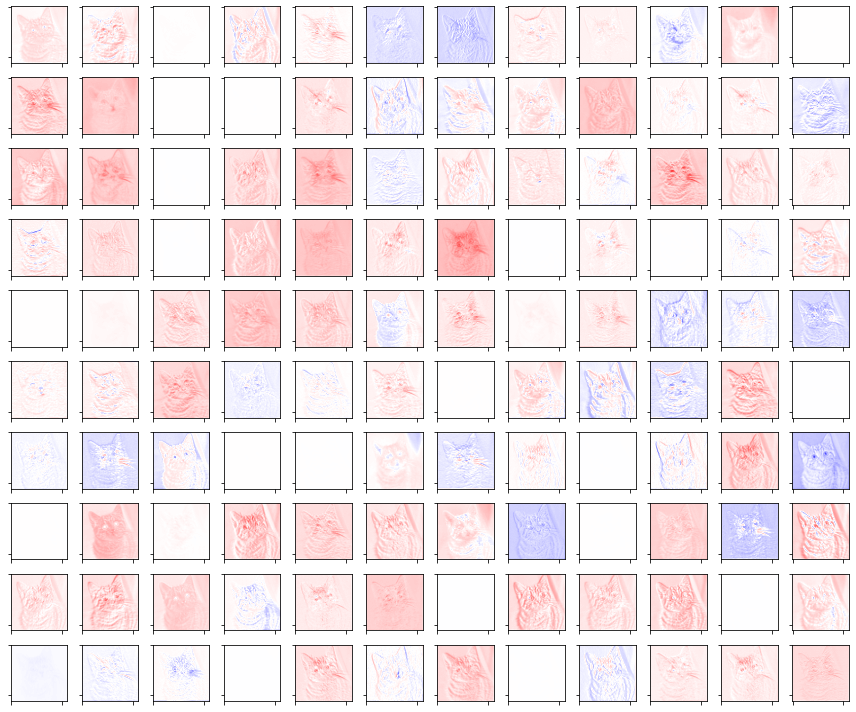

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 128, 112, 112])


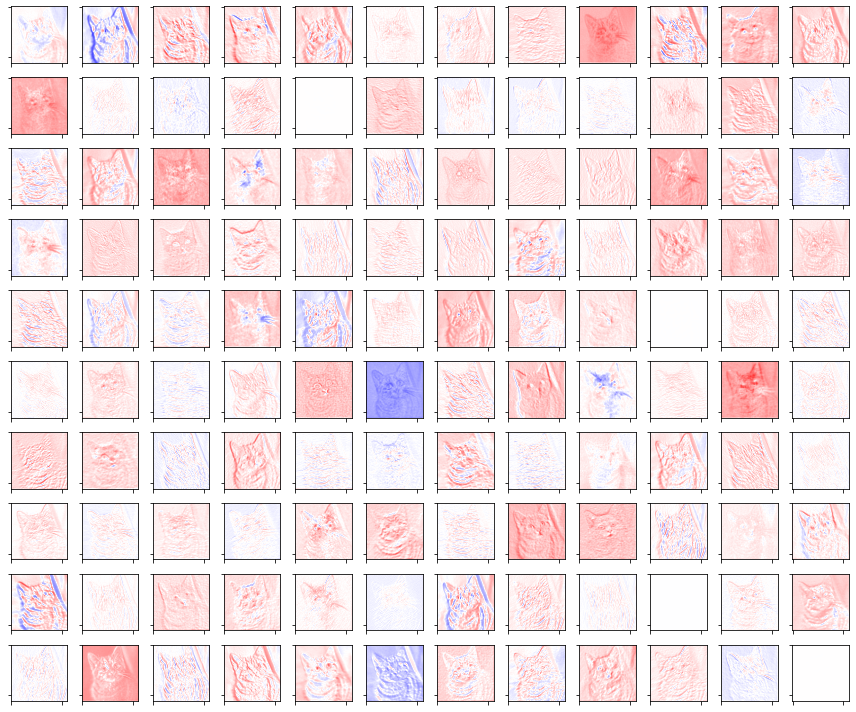

Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 256, 56, 56])


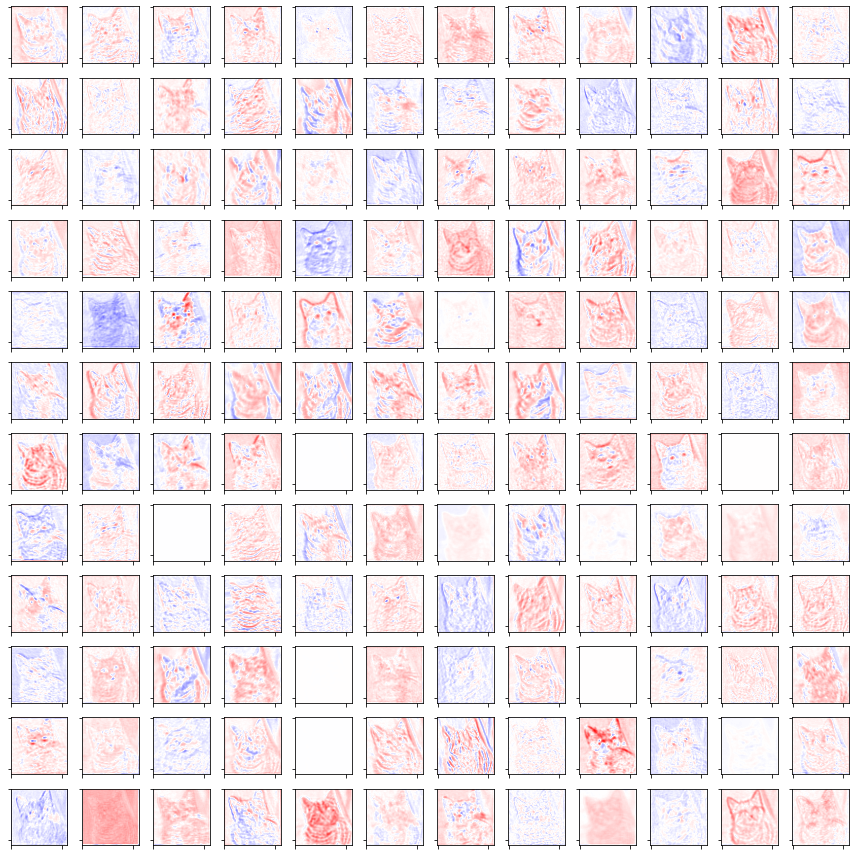

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 256, 56, 56])


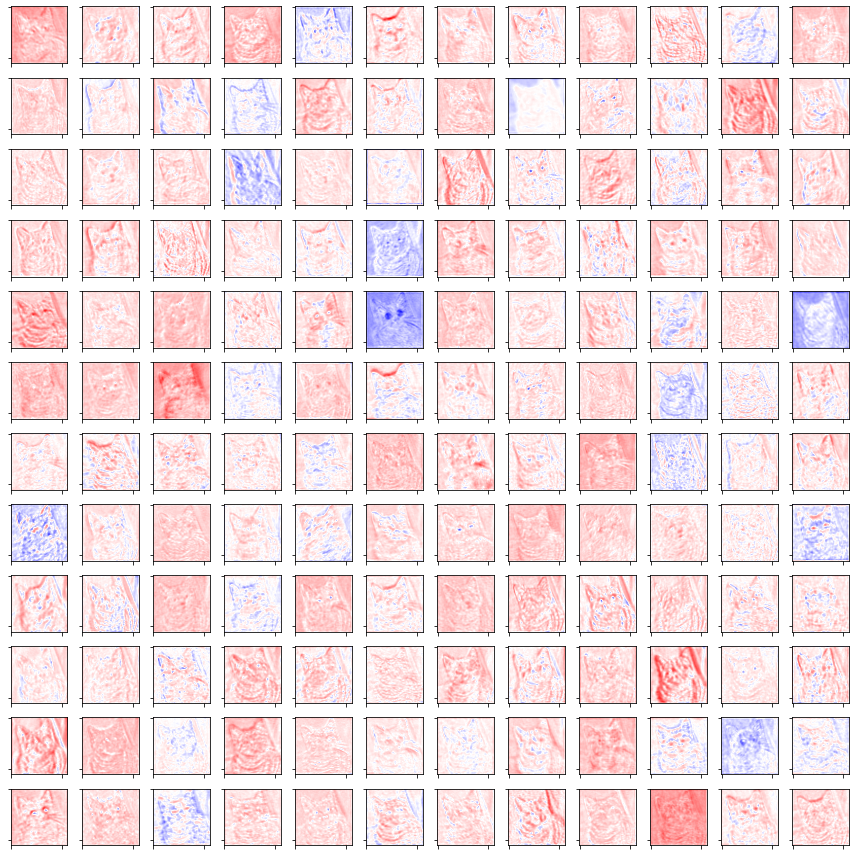

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 256, 56, 56])


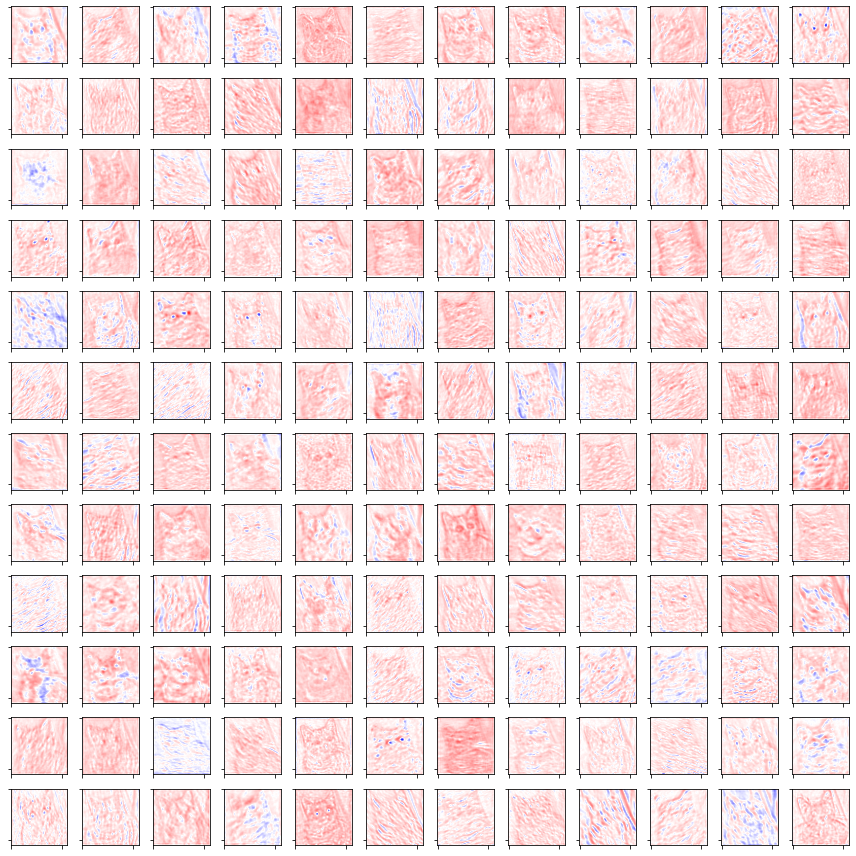

Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 512, 28, 28])


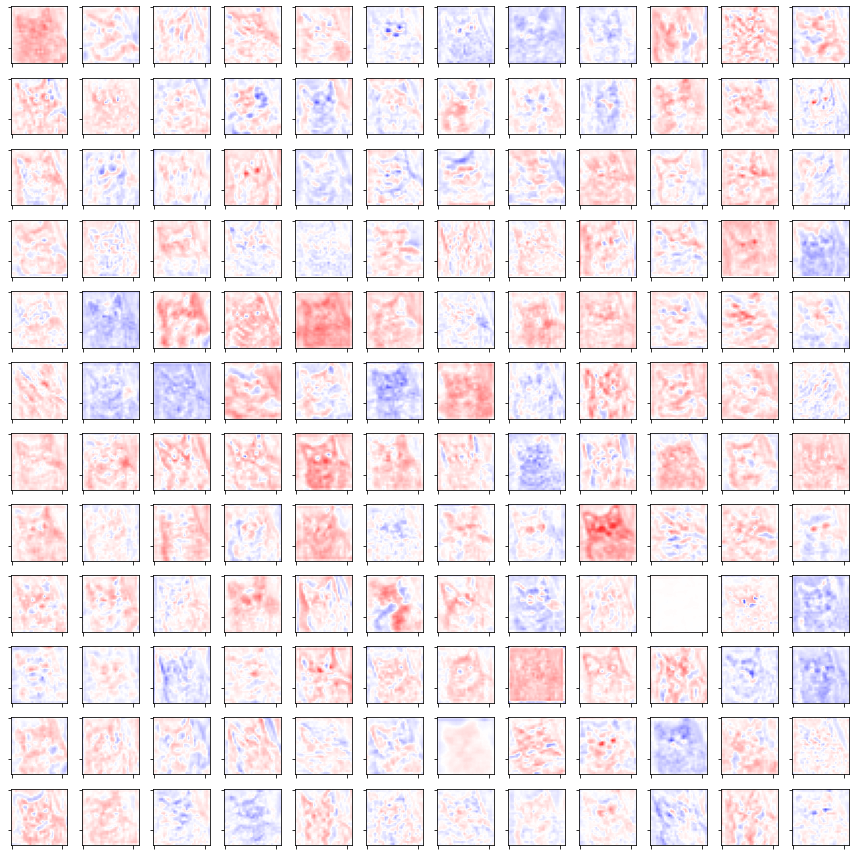

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 512, 28, 28])


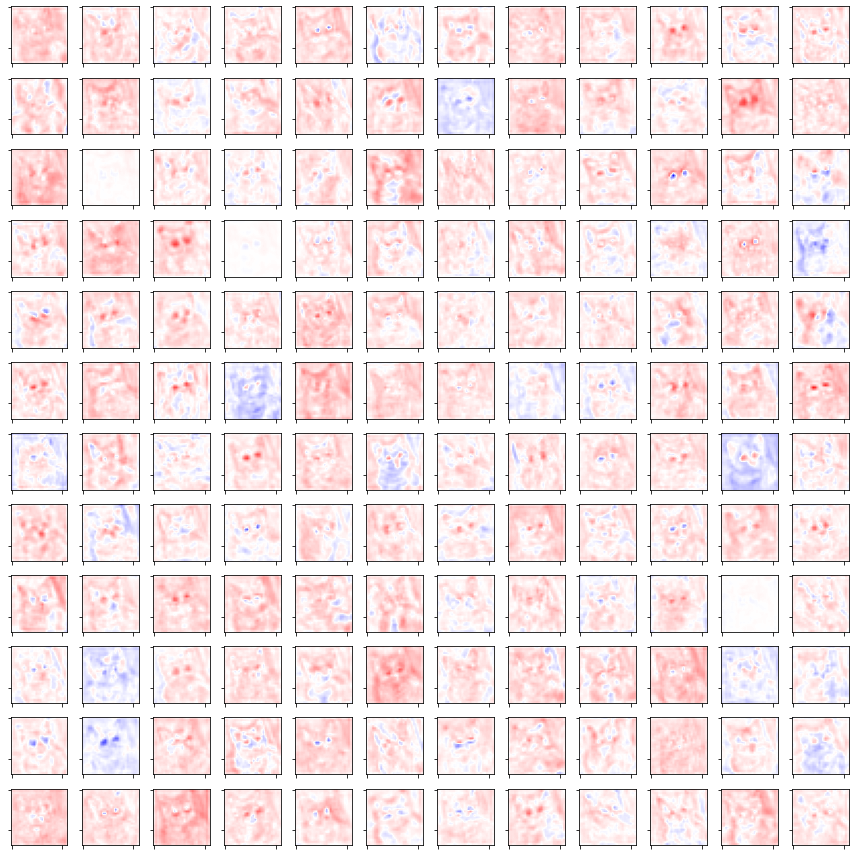

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 512, 28, 28])


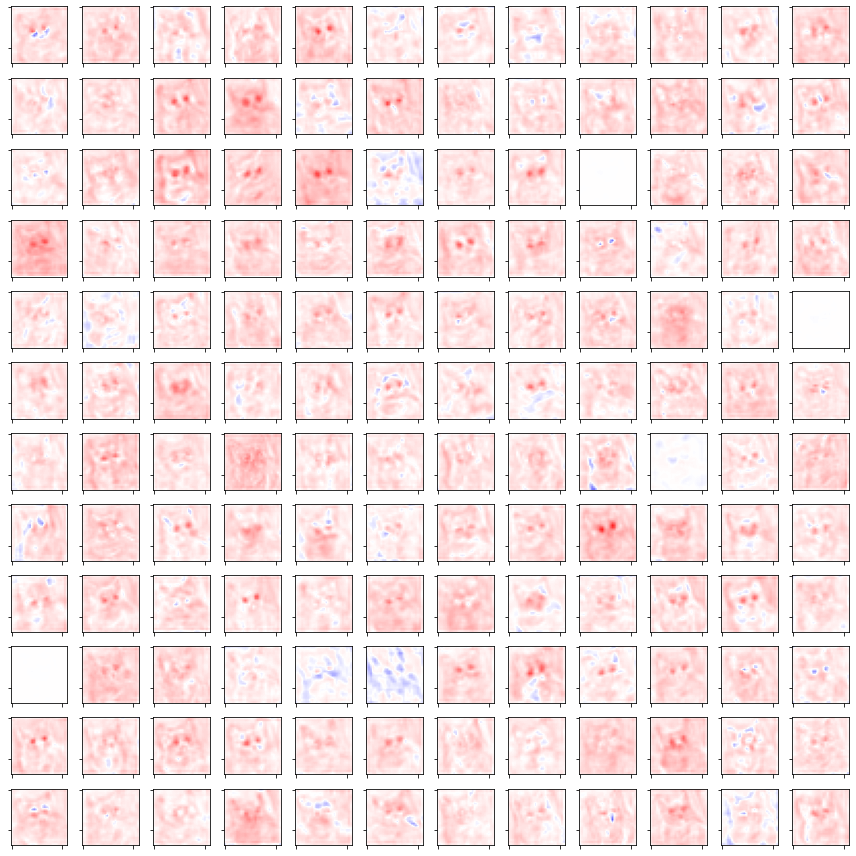

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 512, 14, 14])


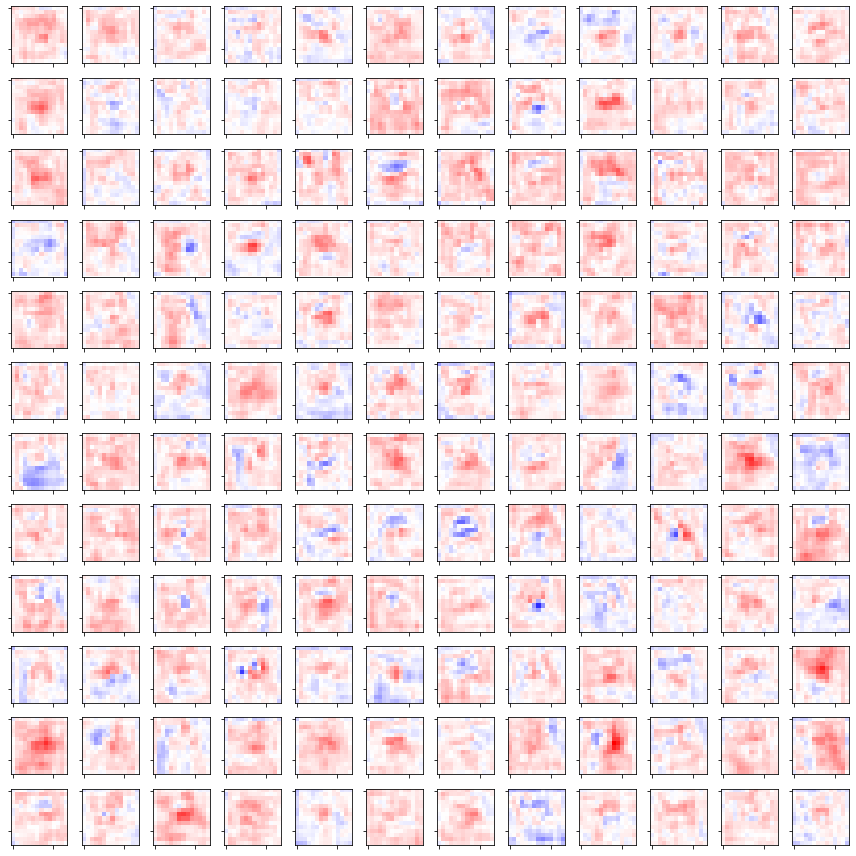

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 512, 14, 14])


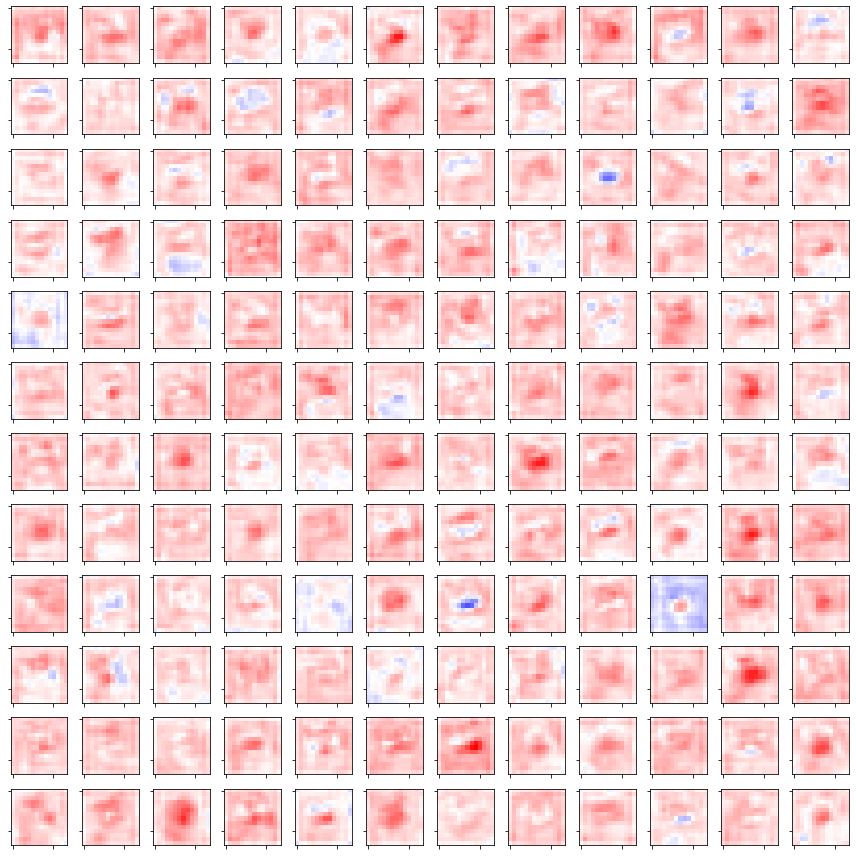

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([1, 512, 14, 14])


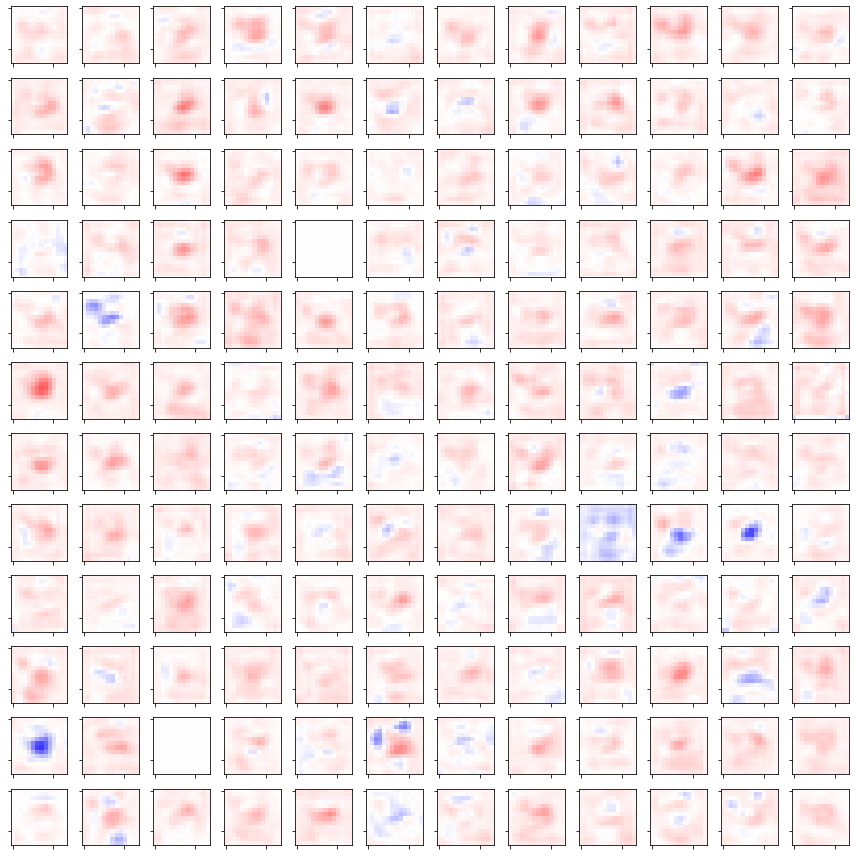

Linear(in_features=25088, out_features=4096, bias=True) torch.Size([1, 4096])


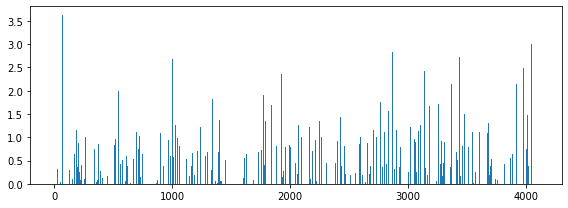

Linear(in_features=4096, out_features=4096, bias=True) torch.Size([1, 4096])


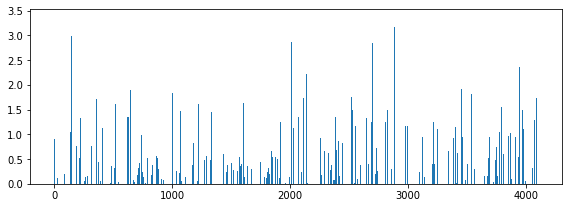

Linear(in_features=4096, out_features=1000, bias=True) torch.Size([1, 1000])


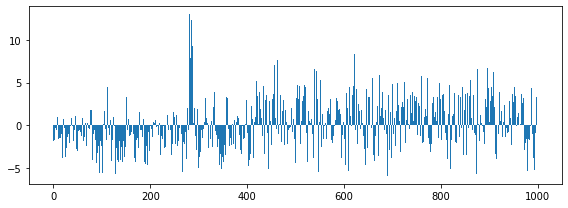

In [ ]:
for k, v in featuremaps.items():
    print(k, v.shape)
    maps = v.squeeze(0).detach().cpu().numpy()
    plotFeaturemaps(maps)#, top=5)


# Explanations<br>解説
<!--
畳み込み演算によって，カーネルに類似した模様が見つかる場所と量（局所特徴量）を表す出力画像が得られることを理解できたでしょうか．このように局所特徴量の分布を表す画像を**特徴マップ（feature map）**といいます．

カーネルを何種類も用意すれば，エッジや凹凸の断片，色の組合せなど，様々な局所特徴について特徴マップを作成できます．３枚の入力で表せるカラー画像から特徴マップを出力するときと同様に，複数の特徴マップからひとつの特徴マップを作ることもできます．
-->

Convolution operations on multiple feature maps representing the distribution of various local features correspond to finding typical combinations of local features. The output feature maps represent the locations and quantities where typical local feature combinations can be found.

The **convolutional layer** creates multiple feature maps from multiple feature maps. The input (output) feature maps are also called input/output channels.

A **convolutional neural network (CNN)** with multiple convolutional layers is a mechanism that searches for combinations of typical local features, combinations of those typical combinations, and so on. Between the convolutional layers, **activation layers** and **pooling layers** are added as needed.

The activation layer facilitates finding typical local features by highlighting or selecting features. The pooling layer reduces the size of the feature map by blurring it. The reduction of the feature map allows for a wider search of the local features.

A **feature extractor** composed of these layers can quantify the features of the input image. The **fully connected (fc) layers** compute the desired quantity from the output of the feature extractor. In the case of object recognition, the fc layers play the role of a **classifier** that calculates the probability of the presence of each assumed object.

<br>

様々な局所特徴量の分布を表す複数の特徴マップに対する畳み込み演算は，局所特徴の典型的な組合せを探すことに相当します．出力の特徴マップは，典型的な局所特徴の組合せが見つかる場所と量を表しています．

畳み込み演算をする**畳み込み層（convolutional layer）**は，複数の特徴マップから複数の特徴マップを作成します．入力（出力）の特徴マップは，入力（出力）チャンネル（input/output channels）とも呼ばれます．

畳み込み層を何段ももつ**畳み込みニューラルネットワーク（convolutional neural network; CNN）**は，典型的な局所特徴の組合せ，その典型的な組合せの組合せ，さらにその組合せ・・を探す機構です．畳み込み層の間には適宜，**活性化層（activation layer）**や**プーリング層（pooling layer）**などが入ります．

**活性化層**は，特徴量を強調または選び出す処理により，典型的な局所特徴を見つけやすくします．プーリング層は特徴マップをぼかしてサイズを縮小します．縮小すると，局所特徴を広目に探せるようになるからです．

こららの層で構成された**特徴抽出器（feature extractor）**によって，入力画像がもつ特徴を定量化できます．**全結合層（fully connected (fc) layers）**は，特徴抽出器の出力から目的の量を算出します．物体認識の場合，全結合層は，想定している各物体が存在する確率を算出する**識別器（classifier）**の役割を担います．

![](https://www.researchgate.net/publication/329790469/figure/fig2/AS:705721712787456@1545268576139/Simplified-illustration-of-the-AlexNet-architecture.ppm)
![](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)


# References<br>参考資料
[VGG](https://arxiv.org/abs/1409.1556)，
[ResNet](https://arxiv.org/abs/1512.03385)，
[Inception](https://arxiv.org/abs/1512.00567)，
[GoogLeNet](https://arxiv.org/abs/1409.4842)，
[参考1](https://medium.com/zylapp/review-of-deep-learning-algorithms-for-image-classification-5fdbca4a05e2)，
[参考2](https://www.topbots.com/important-cnn-architectures/)

![](https://www.researchgate.net/profile/Evgeny-Baraboshkin/publication/335989937/figure/fig3/AS:806501341999104@1569296312136/Neural-networks-architecture-simplified-sketches-inception-and-residual-modules.png)
Neural networks architecture simplified sketches, inception and residual modules structures can be observed in the detailed network maps in online repository ("Supplementary materials to the article," n.d.). 0 -convolutoion layer, 1 -activation layer, 2 -Inception module, 3 -average pooling, 4 -batch normalization, 5 -max pooling, 6 -zero padding, 7 -Residual module, 8 -drop out layer, 9 -layer composition, 10 -dense layer.


![](https://drek4537l1klr.cloudfront.net/elgendy/v-3/Figures/05_27.png)
![](https://i.ytimg.com/vi/VxhSouuSZDY/maxresdefault.jpg)

